In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import json

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
# загрузка подготовленного датасета(уравненного)

data_load = pd.read_csv('git_ignore_files/data_train_merge_120k.csv')
data_load.head(5)

,Unnamed: 0_x,id,vas_id,buy_time,target,Unnamed: 0_y,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
0,578818,2582523,2.0,1531083600,0.0,3360134,314.560029,9.290888,342.989214,7.523202,...,6488.626154,-574.770792,-24.996269,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0
1,604051,981791,2.0,1531083600,0.0,1898019,-81.129971,-392.509112,-95.070786,-445.116798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,604076,3102489,1.0,1531083600,1.0,232405,-96.799971,-408.179112,-110.740786,-460.786798,...,-443.373846,-80.770792,37.003731,21.369552,142.252276,8.167111,-0.694428,19.824067,1.54386,1.0
3,703501,4232031,2.0,1531083600,0.0,235626,-91.959971,-354.749112,-105.900786,-407.356798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,703493,380185,2.0,1531083600,0.0,192209,654.040029,401.980888,640.099214,351.833202,...,-911.373846,-552.770792,-25.996269,-37.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0


In [5]:
# загрузка файла с параметрами для удаления колонок

with open('to_model/parametres.json', 'r') as f:
    param_json = json.load(f)
param_json

{'names': 'datas',
 'drop_column': [75,
  81,
  85,
  95,
  139,
  203,
  41,
  135,
  10,
  0,
  54,
  8,
  91,
  1,
  3,
  6,
  136,
  78,
  44,
  50,
  39,
  12,
  38,
  13,
  40,
  45,
  101,
  42,
  2,
  11,
  209,
  32,
  4]}

In [6]:
# классы для pipeline
# буду описывать непосредственно над классом

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.linear_model import Lasso, Ridge
import statistics
from scipy.stats import iqr

# первичная предобработка - удаление колонок ['id', 'Unnamed: 0_x', 'Unnamed: 0_y', 'buy_time']
# так же удаление из файла json
# оставляем только месяц из даты предложения услуги(день недели везде суббота, год будем считать не важен)

class Preprocess_ful(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x, y=None):
        x = x.copy()
        # колонка buy_time_x - время предложения услуги, берем только месяц тк дни недели везде одинаковые(суббота)
        x['month'] = [datetime.date(datetime.fromtimestamp(i)).month for i in x['buy_time']]     
        # удаление столбцов не нужных
        x.drop(['id', 'Unnamed: 0_x', 'Unnamed: 0_y', 'buy_time'], axis=1, inplace=True)
        #  удаление столбцов с единственным значением
        x.drop([str(i) for i in param_json['drop_column']], axis=1, inplace=True)  
        return x.astype(np.float32)

    
# прописано замена Nan-ов на моду.(на будущее)
# замена выбросов(по 1.5. интерквартильному размаху) на медиану, моду, либо среднее

class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, column, aggfunc, norm):
        self.norm = norm
        self.column = column
        self.aggfunc = aggfunc
#         self.quantil_min = 0.025
#         self.quantile_max = 0.975
        # множитель для среднеквартильного размаха для удаления выбросов
        self.iqr_number = 1.5

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        if self.norm == 'norm':
            x[self.column].fillna(statistics.mode(x), inplace=True)
#             return x[[self.column]]
        elif self.norm == 'transform':
            x[self.column].fillna(statistics.mode(x), inplace=True)
            x[self.column] = self.quantile_data(x[self.column])
        return x[[self.column]]

    def quantile_data(self, x):
        iqr_result = iqr(x) * self.iqr_number
        if self.aggfunc == 'mean':
#             x.fillna(x.mean(), inplace=True)
            x[x < x.median() - iqr_result] = x.mean()
            x[x > x.median() + iqr_result] = x.mean()
        elif self.aggfunc == 'median':
#             x.fillna(x.median(), inplace=True)
            x[x < x.median() - iqr_result] = x.median()
            x[x > x.median() + iqr_result] = x.median()
        elif self.aggfunc == 'moda':
#             x.fillna(x.median(), inplace=True)
            x[x < x.median() - iqr_result] = statistics.mode(x)
            x[x > x.median() + iqr_result] = statistics.mode(x)
        return x

# удаление колонок по обработке данных по Lasso(ниже в коде - после вставлено сюда списком)    

class Drop_column_lasso(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
  
    def transform(self, x, y=None):
        x = pd.DataFrame(x)
        x.drop([11, 74, 76, 77, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 93, 107, 108, 109, 
                110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 
                126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 
                142, 144, 153, 154, 155, 156, 157, 158, 159, 160, 168, 169, 170, 171, 172, 
                173, 180, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 203, 204, 205, 
                206, 207, 208, 209, 210, 211, 212, 213, 214, 219, 220, 224, 225, 226, 227, 
                229, 230, 233, 234, 238, 240, 241, 244, 245, 246, 248, 255, 262, 264], axis=1, inplace=True)
        return x

In [8]:
# создание списка для pipline направляя в классы, далее на FeatureUnion
# преобразование в категориальные признаки колонок где уникальных значений менее 5

pip_transform = []
list_dummy = [i for i in range(253) if len(data_load[f'{i}'].unique()) < 5]

replace_releas = 'median'

for i in list_dummy:
    if not i in param_json['drop_column']:
        pip_transform.append((f'dummy_{i}', Pipeline([('column_dummy', Preprocessing(f'{i}', norm='norm', aggfunc=replace_releas)), # transform
                                          ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])))

for i in ['vas_id', 'month']:
    pip_transform.append((f'dummy_{i}', Pipeline([('column_dummy', Preprocessing(i, norm='norm', aggfunc=replace_releas)), 
                                          ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])))

for i in range(253):
    if not i in list_dummy and not i in param_json['drop_column']:
        pip_transform.append((f'{i}', Pipeline([(f'column_{i}', Preprocessing(f'{i}', norm='transform', aggfunc=replace_releas)),  # transform
                                            ('standardscale', StandardScaler())])))
    # pip_transform.append((f'{i}', Pipeline([(f'column_{i}', Preprocessing(f'{i}', norm='norm')),])))


# FeatureUnion(pip_transform)

In [9]:
# основной pipeline для преобработки

pip = Pipeline([('ful', Preprocess_ful()),
                ('transform', FeatureUnion(pip_transform)),
                ('drop_column', Drop_column_lasso()), 
                ('LR', LogisticRegression())])
pip

Pipeline(steps=[('ful', Preprocess_ful()),
                ('transform',
                 FeatureUnion(transformer_list=[('dummy_15',
                                                 Pipeline(steps=[('column_dummy',
                                                                  Preprocessing(aggfunc='median',
                                                                                column='15',
                                                                                norm='norm')),
                                                                 ('one_hot',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse=False))])),
                                                ('dummy_16',
                                                 Pipeline(steps=[('column_dummy',
                                                                  Preprocessing(aggfunc='median',
                                                                                column='16',
                                                                                norm='norm...
                                                                                sparse=False))])),
                                                ('5',
                                                 Pipeline(steps=[('column_5',
                                                                  Preprocessing(aggfunc='median',
                                                                                column='5',
                                                                                norm='transform')),
                                                                 ('standardscale',
                                                                  StandardScaler())])),
                                                ('7',
                                                 Pipeline(steps=[('column_7',
                                                                  Preprocessing(aggfunc='median',
                                                                                column='7',
                                                                                norm='transform')),
                                                                 ('standardscale',
                                                                  StandardScaler())])), ...])),
                ('drop_column', Drop_column_lasso()),
                ('LR', LogisticRegression())])

# проверка столбцов на категории

In [10]:
# начальная предобработка данных
# просмотр и применение для дальнейшего исследования
pip[0]

Preprocess_ful()

In [11]:
# преобразование данных по первому этапу

df = pd.DataFrame(pip[0].transform(data_load))
df = df.drop(['vas_id', 'target', 'month'], axis=1)
df.head(3)

,5,7,9,14,15,16,17,18,19,20,...,243,244,245,246,247,248,249,250,251,252
0,-13.581790,-65.076096,-30.006538,329.261902,-0.000725,-0.016435,-0.107041,-5.41746,1.401479,28.429184,...,6488.625977,-574.770813,-24.996269,121.369553,142.252274,-16.832888,-0.694429,-11.175933,-0.45614,0.0
1,-466.221802,-65.076096,-30.006538,-61.848110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
2,-481.891785,-65.076096,-30.006538,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,...,-443.373840,-80.770790,37.003731,21.369551,142.252274,8.167111,-0.694429,19.824066,1.54386,1.0


In [12]:
# создание датафрейма в колонках вместо данных, кол-во уникальных признаков столбца

list_categories = []
for i in df.columns:
    list_categories.append(len(df[i].unique()))
df = pd.DataFrame(columns=df.columns)
df.loc[0] = list_categories

In [13]:
# ручной просмотр кол-ва признаков в колонках
print(f'колонки с кол-вом уникальных значений менее 5 {df.columns[df.loc[0] < 5]}')
print(f'кол-во признаков где менее 5 признаков {len(df.columns[df.loc[0] < 5])}')

колонки с кол-вом уникальных значений менее 5 Index(['15', '16', '23', '24', '26', '27', '31', '33', '57', '132', '154',
       '192', '194', '195', '196', '197', '198', '199', '200', '201', '202',
       '204', '205', '206', '216', '218'],
      dtype='object')
кол-во признаков где менее 5 признаков 26


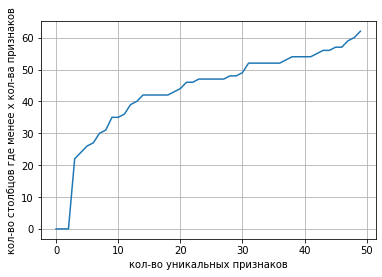

In [14]:
# график кол-ва уникальных признаков 

y = []
x = range(50)
for i in x:
    y.append(len(df.columns[df.loc[0] < i]))

plt.plot(x, y)
plt.xlabel('кол-во уникальных признаков')
plt.ylabel('кол-во столбцов где менее х кол-ва признаков')
plt.grid()
plt.show()

# все признаки где менее 5 уникальных значений переведем в dummy
# добавлено в pip_transform обработка в FeatureUnion

*****************************************************************************************************

# проверка столбцов через Lasso

In [15]:
# преобразования след этапа

data_transform = pd.DataFrame(pip[:2].fit_transform(data_load))
data_transform.head(3)

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.347032,0.357284,3.069939,-0.354096,-0.154723,0.972294,0.0,0.944176,0.0,-0.584999
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,0.0,-0.325796,0.0,-0.584999
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,3.228262,-0.375156,-0.325739,-0.354096,-0.154723,-0.283067,0.0,-0.325796,0.0,1.709404


In [16]:
# импорт необходимых библиотек

from sklearn.linear_model import Lasso, Ridge

lasso_cv = Lasso(alpha=1e-10, random_state=13, fit_intercept=False, max_iter=5).fit(data_transform, data_load['target'])
# ridge_cv = Ridge(alpha=1e-5, random_state=13).fit(data_transform, data_load['target'])

In [17]:
# создаем датафраме и подставляем в названия колонок коээфициенты Lasso

df = pd.DataFrame(columns=data_transform.columns)
df.loc[0] = lasso_cv.coef_
df

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,0.500003,0.378179,0.362486,0.373377,-0.000009,0.219985,0.148438,0.000005,-0.61476,0.000001,...,-0.001244,-0.000977,-0.000394,-0.000741,-0.001085,-0.001124,0.0,-0.000513,0.0,0.00123


In [18]:
# кол-во нулевых колонок

len(df.columns[df.loc[0] == 0])

107

In [19]:
# этот список нулевых колонок копируем и вставляем в класс Drop_column_lasso

drop_column_lasso = df.columns[df.loc[0] == 0]
print(list(drop_column_lasso))

[11, 74, 76, 77, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 93, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 144, 153, 154, 155, 156, 157, 158, 159, 160, 168, 169, 170, 171, 172, 173, 180, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 219, 220, 224, 225, 226, 227, 229, 230, 233, 234, 238, 240, 241, 244, 245, 246, 248, 255, 262, 264]


# проверка преобразования данных

In [20]:
# проверка преобразования данных в pipeline перед моделью машинного обучения

pip[:3].fit_transform(data_load, data_load['target'])

,0,1,2,3,4,5,6,7,8,9,...,253,254,256,257,258,259,260,261,263,265
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.375739,-0.406466,-0.347032,0.357284,3.069939,-0.354096,-0.154723,0.972294,0.944176,-0.584999
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.091227,0.199341,3.228262,-0.375156,-0.325739,-0.354096,-0.154723,-0.283067,-0.325796,1.709404
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.400980,-0.507434,-0.020743,0.770456,-0.325739,-0.354096,-0.564556,-0.462404,0.944176,1.709404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120367,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.375739,1.410956,-0.423397,-0.375156,-0.325739,-0.354096,2.178176,-0.283067,2.214148,-0.584999
120368,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999
120369,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.375739,0.249825,0.000084,0.901919,-0.325739,-0.354096,1.295458,-0.462404,-0.325796,-0.584999
120370,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999


# расчеты метрик

In [21]:
# функция для расчета максимального скора. 

def image(y_pred, y):
  # возвращает список numpy первым столбцом идет f1_score вторым порог деления
  f1 = []
  q = [i/100 for i in range(10, 91)]
  for j in q:
    y_pr = [1 if i > j else 0 for i in y_pred[:,1]]
    f1.append([f1_score(y, y_pr, average='macro'), j])
  return np.array(f1)

In [22]:
# разделяем на трайн и тест

x_1, x_2, y_1, y_2 = train_test_split(data_load.drop('target', axis=1), data_load['target'], test_size=0.3, random_state=13)
pip.fit(x_1, y_1)
y_pred_test = pip.predict_proba(x_2)
y_pred_train = pip.predict_proba(x_1)
y_pred_test

array([[0.32467989, 0.67532011],
       [0.90336218, 0.09663782],
       [0.90982239, 0.09017761],
       ...,
       [0.24661454, 0.75338546],
       [0.0179723 , 0.9820277 ],
       [0.89899258, 0.10100742]])

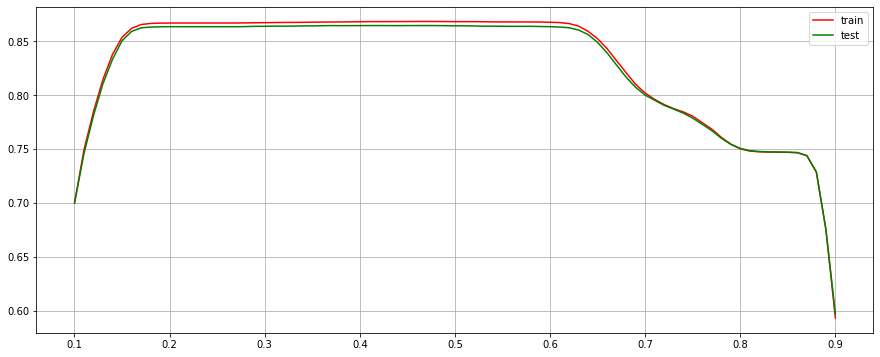

наилуший порог test: 0.47, f1 = 0.8643550174124556
наилуший порог train: 0.47, f1 = 0.868145934626902
значение f1 test при пороге от train: 0.8643550174124556


In [23]:
# построим график f1_score логистической регрессии по порогам разбиения

from sklearn.metrics import f1_score, precision_recall_curve

f1_train = image(y_pred_train, y_1)
f1_test = image(y_pred_test, y_2)
plt.figure(figsize=(15,6))
plt.plot(f1_train[:, 1], f1_train[:, 0], c='red', label='train')
plt.plot(f1_test[:, 1], f1_test[:, 0], c='green', label='test')
plt.legend()
plt.grid()
plt.show()

th_train = np.argmax(f1_train[:, 0])
th_test = np.argmax(f1_test[:, 0])

print(f'наилуший порог test: {f1_test[th_test][1]}, f1 = {f1_test[th_test][0]}')
print(f'наилуший порог train: {f1_train[th_train][1]}, f1 = {f1_train[th_train][0]}')
print(f'значение f1 test при пороге от train: {f1_test[th_train][0]}')

In [24]:
# подключаем xgboost

from xgboost.sklearn import XGBClassifier

pip_xgb = Pipeline([('ful', Preprocess_ful()),
                ('transform', FeatureUnion(pip_transform)), 
                ('drop_column', Drop_column_lasso()),
                ('LR', XGBClassifier(eta=0.01, reg_alpha=0.0001, n_estimators=500,  
                                     random_state=13, eval_metric='auc', n_jobs=-1, 
                                     max_depth=5, tree_method='gpu_hist', objective='binary:logistic'))])  # n_est=150

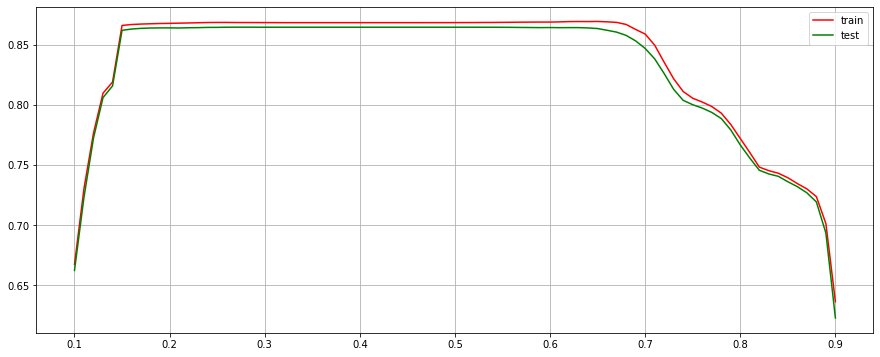

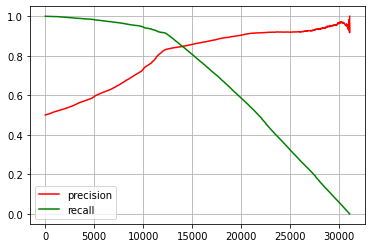

In [25]:
# построим график f1_score xgboost по порогам разбиения

pip_xgb.fit(x_1, y_1)
y_pred_test = pip_xgb.predict_proba(x_2)
y_pred_train = pip_xgb.predict_proba(x_1)
f1_train = image(y_pred_train, y_1)
f1_test = image(y_pred_test, y_2)
plt.figure(figsize=(15,6))
plt.plot(f1_train[:, 1], f1_train[:, 0], c='red', label='train')
plt.plot(f1_test[:, 1], f1_test[:, 0], c='green', label='test')
plt.legend()
plt.grid()
plt.show()

pr, rec, th, = precision_recall_curve(y_2, pip_xgb.predict_proba(x_2)[:, 1])
x = range(len(rec))
plt.plot(x, pr, c='red', label='precision')
plt.plot(x, rec, c='green', label='recall')
plt.legend()
plt.grid()
plt.show()

In [26]:
# лучший порог разбиения и метрика

gg = image(y_pred_test, y_2)
threshold = gg[:,1][np.argmax(gg[:,0])]
print(f'лучший порог {threshold}')
print(f1_score(y_2, [1 if i>threshold else 0 for i in y_pred_test[:,1]], average='macro'))


from save_file_param import save_json
save_json('xgb', threshold)

лучший порог 0.27
0.8644090751140217


'Записано'

In [27]:
# нахождение лучшего порога через гармоническое среднее

from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
pres, rec, thres = precision_recall_curve(y_2,  pip_xgb.predict_proba(x_2)[:, 1])
q = 1 ** 2
x = (1+q) * pres * rec / (q*pres + rec)
threshold = np.argmax(x, axis=0)
y_pred_out = [1 if i > thres[threshold] else 0 for i in pip_xgb.predict_proba(x_2)[:, 1]]
print('f1_score= ', f1_score(y_2, y_pred_out, average='macro'))
confusion_matrix(y_2, y_pred_out)

f1_score=  0.8644364675301485


array([[14740,  3321],
       [ 1563, 16488]])

In [28]:
# подбор параметров через гридсерч

from sklearn.model_selection import GridSearchCV

score = 'f1'
param = {
    'n_estimators': [50, 150, 500, 1000],
    'eta': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [3, 5, 8, 12],
    'reg_alpha': [0.0001, 0.001, 0.01]
}

In [29]:
# adf = pip_xgb[:3].fit_transform(x_1, y_1)
# import time
# start = time.time()
# print(start)
# xg = XGBClassifier( eval_metric='rmse', random_state=13, tree_method='gpu_hist', predictor='gpu_predictor', n_jobs=-1)
# grid_search = GridSearchCV(estimator=xg, param_grid=param, scoring=score, verbose=1, cv=2)
# grid_search.fit(adf, y_1)
# print(time.time() - start)
# grid_search.best_params_, grid_search.best_score_

In [30]:
# grid_search.best_params_, grid_search.best_score_
# {'eta': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.0001}
# {'eta': 0.01, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0.0001} 

In [31]:
# сохранение модели в pickle

import pickle
with open('models/model.pkl', 'wb') as f:
    pickle.dump(pip_xgb, f)

In [32]:
# сохранение модели в dill

import dill
with open('models/model_dill.pkl', 'wb') as f:
    dill.dump(pip_xgb, f)

In [33]:
# pickle.dump?

# кластеризация и PCA

In [34]:
# преобразование данных для этапа

data_transform = pip_xgb[:3].fit_transform(data_load)
data_transform

,0,1,2,3,4,5,6,7,8,9,...,253,254,256,257,258,259,260,261,263,265
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.375739,-0.406466,-0.347032,0.357284,3.069939,-0.354096,-0.154723,0.972294,0.944176,-0.584999
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.091227,0.199341,3.228262,-0.375156,-0.325739,-0.354096,-0.154723,-0.283067,-0.325796,1.709404
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.400980,-0.507434,-0.020743,0.770456,-0.325739,-0.354096,-0.564556,-0.462404,0.944176,1.709404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120367,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.375739,1.410956,-0.423397,-0.375156,-0.325739,-0.354096,2.178176,-0.283067,2.214148,-0.584999
120368,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999
120369,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.375739,0.249825,0.000084,0.901919,-0.325739,-0.354096,1.295458,-0.462404,-0.325796,-0.584999
120370,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.426221,-0.507434,-0.478936,-0.375156,-0.325739,-0.354096,-0.858796,-0.641742,-0.325796,-0.584999


In [35]:
# проверка скора при простой кластеризации

from sklearn.cluster import KMeans
k = KMeans(n_clusters=2).fit(data_transform)

from sklearn.metrics import f1_score
f1_score(data_load['target'], k.labels_, average='macro')

0.4965283212303948

In [36]:
# подключение PCA

from sklearn.decomposition import PCA
data_transform_pca = data_transform.copy()
pca = PCA(n_components=2).fit_transform(data_transform_pca)
pca

array([[-0.47753022,  1.02295484],
       [-5.24890043, -2.84955742],
       [ 5.66249848,  1.90631329],
       ...,
       [-5.63033396,  3.35667754],
       [-3.61547004, -3.25172941],
       [-0.48531646, -2.54187683]])

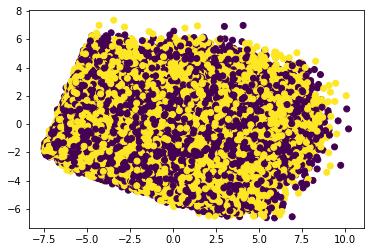

In [37]:
plt.scatter(pca[:,0], pca[:,1], c=data_load['target'])

In [38]:
pca = PCA(n_components=10).fit(data_transform)
pca.explained_variance_ratio_

array([0.15560474, 0.05014363, 0.029983  , 0.02720616, 0.02447803,
       0.02295193, 0.01987012, 0.01931522, 0.01825828, 0.01730858])

In [39]:
pcaa = PCA(0.99)
pcaa.fit_transform(data_transform).shape

(120372, 97)

# 99% информации в 97 колонках. далее применим PCA в модели

In [40]:
# добавляем в pipeline PCA

from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve

pip_xgb_pca = Pipeline([('ful', Preprocess_ful()),
                ('transform', FeatureUnion(pip_transform)), 
                ('drop_column', Drop_column_lasso()),
                ('pca', PCA(n_components=81)),
                ('LR', XGBClassifier(eta=0.01, reg_alpha=0.05, n_estimators=50,  
                                     random_state=13, eval_metric='auc', n_jobs=-1, 
                                     max_depth=11, tree_method='gpu_hist', objective='binary:logistic'))])  # n_est=150

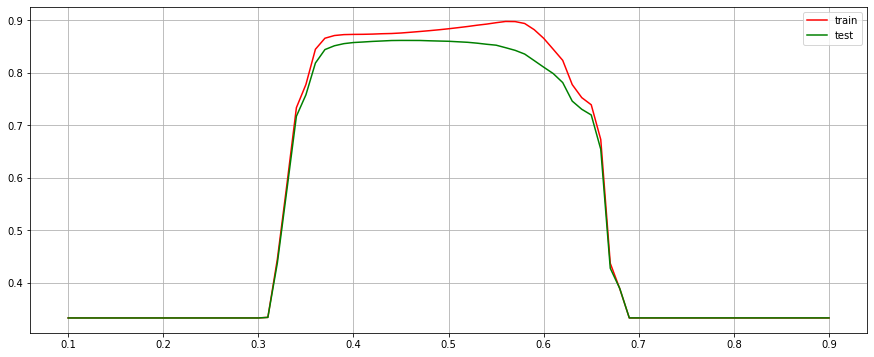

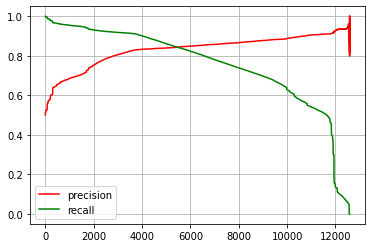

In [41]:
# отрисовка метрики f1 по порогу разделения

pip_xgb_pca.fit(x_1, y_1)
y_pred_test = pip_xgb_pca.predict_proba(x_2)
y_pred_train = pip_xgb_pca.predict_proba(x_1)
f1_train = image(y_pred_train, y_1)
f1_test = image(y_pred_test, y_2)
plt.figure(figsize=(15,6))
plt.plot(f1_train[:, 1], f1_train[:, 0], c='red', label='train')
plt.plot(f1_test[:, 1], f1_test[:, 0], c='green', label='test')
plt.legend()
plt.grid()
plt.show()

pr, rec, th, = precision_recall_curve(y_2, pip_xgb_pca.predict_proba(x_2)[:, 1])
x = range(len(rec))
plt.plot(x, pr, c='red', label='precision')
plt.plot(x, rec, c='green', label='recall')
plt.legend()
plt.grid()
plt.show()

In [42]:
# лучший порог

gg = image(y_pred_test, y_2)
threshold = gg[:,1][np.argmax(gg[:,0])]
f1_score(y_2, [1 if i>threshold else 0 for i in y_pred_test[:,1]], average='macro')

from save_file_param import save_json
save_json('xgb_pca', threshold)

'Записано'

In [43]:
import dill
with open('models/model_pca_dill.pkl', 'wb') as f:
    dill.dump(pip_xgb_pca, f)

# попробуем подобрать параметры через gridsearch

In [ ]:
# adf = pip_xgb_pca[:4].fit_transform(x_1, y_1)
# import time
# start = time.time()
# print(start)
# xg = XGBClassifier( eval_metric='rmse', random_state=13, tree_method='gpu_hist', predictor='gpu_predictor', n_jobs=-1)
# grid_search = GridSearchCV(estimator=xg, param_grid=param, scoring=score, verbose=1, cv=2)
# grid_search.fit(adf, y_1)
# print(time.time() - start)
# grid_search.best_params_, grid_search.best_score_
# {'eta': 0.1, 'max_depth': 12, 'n_estimators': 1000, 'reg_alpha': 0.001}